<div class="alert alert-info">Chicago Airbnb-Steiner bk3</div><p>
You and a group of friends are considering purchasing a property in Chicago that you can use as an investment. You have heard from other people that they have made a lot of money by renting out either a room or an entire unit (apartment or house). 
    <p>

Your friends ask you to analyze data so that they can understand how much you would charge per night based on the type of dwelling you were to purchase.

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
#import the sql package
from sqlalchemy import create_engine
import psycopg2
from sqlalchemy import create_engine, text

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('C:/Users/jenni/Documents/MSDS/MSDS610/random.csv')
ddf=df

In [4]:
#set up variable for the db
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db for this class
user = r'postgres' # using the postgres user because I'm too lazy to create a new one
pw = r'BrightBlessings1!' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'cleaned' # schema 

In [5]:
#open the connection
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

We are using g the random.csv.  I have drawn that into dataframe df. 
<br>I have also created and opened the database connection.
<br>I created ddf so that the predicition can be added to it

<p>As noted in cleaned.dbo.etl_manipulations, all that is being kept are the 5 features below
<br>Instead of using get dummies  I'm using replace.  Mostly because I'm not sure that 'flattening' the data is best.
<br>I wasn't able to figure out how to bring in the bring in the column names and feed them into the dataframe selection.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      400 non-null    int64  
 1   id                              400 non-null    int64  
 2   name                            400 non-null    object 
 3   host_id                         400 non-null    int64  
 4   host_name                       400 non-null    object 
 5   neighbourhood_group             0 non-null      float64
 6   neighbourhood                   400 non-null    object 
 7   latitude                        400 non-null    float64
 8   longitude                       400 non-null    float64
 9   room_type                       400 non-null    object 
 10  price                           400 non-null    int64  
 11  minimum_nights                  400 non-null    int64  
 12  number_of_reviews               400 

In [7]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      400 non-null    int64  
 1   id                              400 non-null    int64  
 2   name                            400 non-null    object 
 3   host_id                         400 non-null    int64  
 4   host_name                       400 non-null    object 
 5   neighbourhood_group             0 non-null      float64
 6   neighbourhood                   400 non-null    object 
 7   latitude                        400 non-null    float64
 8   longitude                       400 non-null    float64
 9   room_type                       400 non-null    object 
 10  price                           400 non-null    int64  
 11  minimum_nights                  400 non-null    int64  
 12  number_of_reviews               400 

In [8]:
df1=df[["id", "room_type","price","minimum_nights","availability_365"]]

I guessed that the reason for the etl table was so we could connect and use the values to automate the manipulations 
<br>I was able to figure out how to use a cursor to filter price and min nights.  This should meet the UDF requirement
<br>  This part was a bit challenging and I spent a while researching and figuring out why I kept getting errors.  I finally found an article that noted postgres changes table names to lower case.  I had originallyset the table up with mixed case.

In [9]:

# forming the connection 
conn = psycopg2.connect( 
    database=db, user=user, 
    password=pw, host=host, port=port,
    options='-c search_path=dbo,cleaned'
) 
  

# Creating a cursor object using the 
# cursor() method 
cursor = conn.cursor() 

udf_sql ="SELECT max_value from  etl_manipulations where field_name ='price'"

# executing the sql command 
cursor.execute(udf_sql) 
  
# fetching one row 
result = cursor.fetchone() 

df2 = df1[df1['price'] < result]
cursor.close()


In [10]:

# Creating a cursor object using the 
# cursor() method 
cursor = conn.cursor() 

sql_udf ="SELECT max_value from  etl_manipulations where field_name ='minimum_nights'"

# executing the sql command 
cursor.execute(sql_udf) 
  
# fetching one row 
result = cursor.fetchone() 

df2 = df1[df1['minimum_nights'] < result]
cursor.close()


Although I was able to figure out how to pull in the max values for filters, trying to get the calculated fields to work wasn't in my wheelhouse

In [11]:
df2['minimum_cost']=df2['minimum_nights']*df2['price']

In [12]:
df2['possible_income']=df2['minimum_cost']*df2['availability_365']

Check the data and load the model

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 0 to 399
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                397 non-null    int64 
 1   room_type         397 non-null    object
 2   price             397 non-null    int64 
 3   minimum_nights    397 non-null    int64 
 4   availability_365  397 non-null    int64 
 5   minimum_cost      397 non-null    int64 
 6   possible_income   397 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 24.8+ KB


Loading the x_val, y_val and the model.  

In [14]:
 # Load the saved model
loaded_model = joblib.load('bnb_rf_model.joblib')
loaded_x_val = joblib.load('x_val.joblib')
loaded_y_val = joblib.load('y_val.joblib')
print("Model loaded successfully")


# Make predictions on the validation set
y_val_pred = loaded_model.predict(loaded_x_val)
#gather up names of all the columns


Model loaded successfully


In [15]:
accuracy_score(loaded_y_val,y_val_pred)

0.8554083885209713

The accuracy looks good still for the validation data

In [16]:
X_new = df2.drop('room_type', axis=1) # Adjust as needed

In [17]:
predictions = loaded_model.predict(X_new)

In [18]:
y_new = df2['room_type']
    
    # Evaluate the model
accuracy = accuracy_score(y_new, predictions)
report = classification_report(y_new, predictions)
    
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.47858942065491183
Classification Report:
                 precision    recall  f1-score   support

Entire home/apt       0.47      0.93      0.62        98
     Hotel room       1.00      0.20      0.33       100
   Private room       0.39      0.65      0.49       100
    Shared room       0.93      0.14      0.25        99

       accuracy                           0.48       397
      macro avg       0.70      0.48      0.42       397
   weighted avg       0.70      0.48      0.42       397



If I understand the classification report, the model is best in respect to Entre home/apt


Next, save the prediction results.
Save the results of prediction to the db.  Then save to csv and concantonate to the original dataset

In [19]:
dfa = pd.DataFrame(predictions)

dfa.columns = ["prediction"]
dfa.to_csv("prediction_results.csv")

In [20]:
table_name = r'bnb_pred'
schema = r'analytics' # schema we created this week.

dfa.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

397

In [21]:

df4 = pd.concat([ddf, dfa], axis=1)

In [22]:
table_name = r'bnb_predcomb'
schema = r'analytics' # schema we created this week.

df4.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

400

In [23]:
df4.to_csv('C:/Users/jenni/Documents/MSDS/MSDS610/bnb_preds.csv')

<div class="alert alert-info"><b> Summary </b></div><p>

The analytical question:  Your friends ask you to analyze data so that they can understand how much you would charge per night based on the type of dwelling you were to purchase.
<p>The data set was fairly clean.  The NaN's found were in columns that were not needed for the analysis.  In moving through the EDA portion, it occurred to me that doing a full model was likely a bit of overkill.  <br>
The question being asked could have been answered with basic analysis and calculations--i.e. calculate for the average daily cost across all ids, grouped by the type of dwelling and in what neighborhood.  
There's several ways that the data could be broken apart to give a one time answer to 'How much should we charge'.  
<p> When I reconsidered the question, it also occurred to me that the data will change continuously.  Today it might be 50 per night, tomorrow it could be 100.  This justifies creating a model that will accept new/live data for an ongoing 
prediction.  I did find the data set to be lacking a bit in detail.  The analysis could have been a great deal more in depth if things like square footage of the rental was included or a neighborhood rating was also included.  That is to say
that if a rental is in a 5 star neighborhood, with 4000sq it makes sense that the minimum rental fee would be 4k a week.  Whereas a 400 sf rental in a 1 star neighborhood is definitely not going to command that 4k income.  Just the same
there is no indication of times of year on pricing.  Does pricing go up over holidays?  Is there a booking discount for longer stays?</p>
<p>This was run twice.  Once with a sample of 25 per room type category and once with 100 per category.  Once basic cleaning was completed, the guideance was entered into the etl_manipulations for use during deployment.  A 3 way split was done before using a Random 
Tree Classifier for the model.  The validation data was saved off to csv and used when the model was loaded (book 3) to verify.  The test/training runs (for both 25 and 100 random) showed promising accuracy results. 
However, for both executions of the model, when the live data was brought in accuracy dropped dramatically.  The classification report did show the best accuracy was found to be for Entire House/Apt.  
I'm fairly certain the reason for the drop in accuracy is due to the smaller input of data records that was used for live.  Future data sets will need to be monitored to ensure minimal data drift and to test for new features that may be of use.</p>

<div class="alert alert-info"><b> Final Thoughts </b></div><p>

This project definitely left me in tears more than once.  Felt pretty dumb aftr I finally read your comments from the Wk6 assignment.  It was definitely a face/palm moment.  And once I stepped back and applied 
what I didn't grasp before, everything fell into place, went easily and smoothly.  
<p>I wanted to do more with drawing the parameters in from the etl_manipulations table, however, it eluded me on how to bring in the calculations from the table itself--i.e. price*minimum_nights and price*availability_365.  I got rather frustrated
with it.  I was able to bring in the max value for filtering, yet I know there is a way to do it.  I 'fought' with this part of things initially, trying to figure out why I kept getting an error.  I had to do a lot of digging before I found
the answer and redid the table name, making it lower case.  I'm sure that like SQL Server, there's a way to force postgres into seeing mixed case, I just haven't found it yet.</p>
<p>Thank you for being patient and working with me during this term.  I have appreciated it!</p>

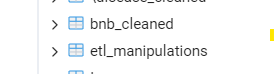


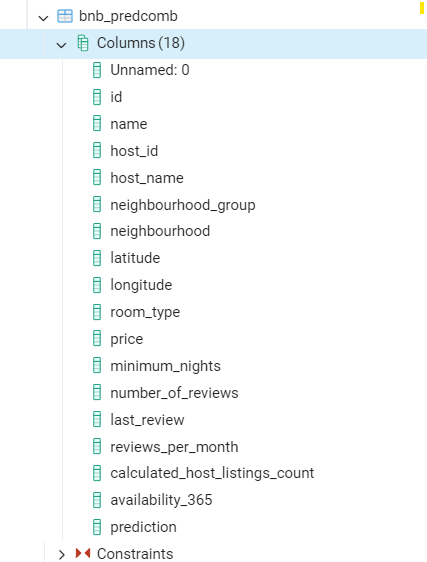


References used:
<p>https://stackoverflow.com/questions/695289/cannot-simply-use-postgresql-table-name-relation-does-not-exist</p>
<p>https://stackoverflow.com/questions/34864695/saving-prediction-results-to-csv
<p>https://plainenglish.io/blog/importing-csv-data-into-postgresql-using-python
<p>https://stackoverflow.com/questions/59298580/how-to-specify-schema-in-psycopg2-connection-method
<p>https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/</p>
<p>https://www.analyticsvidhya.com/blog/2023/02/how-to-save-and-load-machine-learning-models-in-python-using-joblib-library/</p>
<p>https://www.statology.org/sklearn-classification-report/</p>